# Inference

In [17]:
import diffusers
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor
import torch
import cv2
import numpy as np
import os
import random
from tqdm import tqdm
from PIL import Image 

model_path = '/home/sonia/cycloneSVD/windmag_atlanticpacific2/'
ckpt_name = 'checkpoint-7000'
real_data_path = '/home/cyclone/train/windmag_atlanticpacific'

In [18]:
# feature_extractor = CLIPImageProcessor.from_pretrained('/mnt/data/sonia/svd/outputs/feature_extractor')
# image_encoder = CLIPVisionModelWithProjection.from_pretrained('/mnt/data/sonia/svd/outputs/image_encoder')
# scheduler = diffusers.DDPMScheduler.from_pretrained("/mnt/data/sonia/svd/outputs/scheduler")
# unet = diffusers.UNetSpatioTemporalConditionModel.from_pretrained('/mnt/data/sonia/svd/outputs/unet')
# vae = diffusers.AutoencoderKLTemporalDecoder.from_pretrained('/mnt/data/sonia/svd/outputs/vae')
feature_extractor = CLIPImageProcessor.from_pretrained(os.path.join(model_path, 'feature_extractor'))
image_encoder = CLIPVisionModelWithProjection.from_pretrained(os.path.join(model_path, 'image_encoder'))
scheduler = diffusers.DDPMScheduler.from_pretrained(os.path.join(model_path, 'scheduler'))
unet = diffusers.UNetSpatioTemporalConditionModel.from_pretrained(os.path.join(model_path, ckpt_name, 'unet'))
vae = diffusers.AutoencoderKLTemporalDecoder.from_pretrained(os.path.join(model_path, 'vae'))
pipeline = diffusers.StableVideoDiffusionPipeline.from_pretrained(
    'stabilityai/stable-video-diffusion-img2vid',
    image_encoder=image_encoder,
    vae=vae,
    unet=unet,
    # revision=args.revision,
)
width = height = 32
num_frames = 8
n = 1 # desired eval set size

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00, 991.61it/s]


In [54]:
outputdir = os.path.join(model_path, ckpt_name, 'synth') #FKA evals
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
allexamples = os.listdir(real_data_path)
examples = random.sample(allexamples, n)
examples = ['19880121120440013000']
with open(os.path.join(outputdir, 'examples.txt'), 'w+') as f:
    f.write('\n'.join(examples))
preds = []

pipeline = pipeline.to('cuda')
for example in tqdm(examples):
    imgs = [] 
    for i in range(num_frames):
        frame_path = os.path.join(real_data_path, example, f'{i}.npy')
        img = Image.fromarray(np.load(frame_path))
        img_resized = img.resize((224,224))
        img_tensor = torch.from_numpy(np.array(img_resized)).float()
        img_normalized = img_tensor / 255
        img_normalized = img_normalized.unsqueeze(0).repeat([3,1,1]).unsqueeze(0)  
        imgs.append(img_normalized)
        
    sample = pipeline(
        imgs[0],
        height=height,
        width=width,
        num_frames=num_frames,
        decode_chunk_size=8,
        motion_bucket_id=127,
        fps=7,
        noise_aug_strength=0.02,
    ).frames[0]
    preds.append(sample)
    os.makedirs(os.path.join(outputdir, example), exist_ok=True)
    for i in range(num_frames):
        frame_arr = np.array(sample[i])
        np.save(os.path.join(outputdir, example, f'{i}.npy'), frame_arr)
pipeline = pipeline.to('cpu')

100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


In [55]:
pred = [np.asarray(p) for p in preds[0]]

In [64]:
img.mean(axis=-1).shape

(32, 32)

56 0 (32, 32)
50 0 (32, 32)
50 0 (32, 32)
51 0 (32, 32)
58 0 (32, 32)
55 0 (32, 32)
53 0 (32, 32)
54 0 (32, 32)


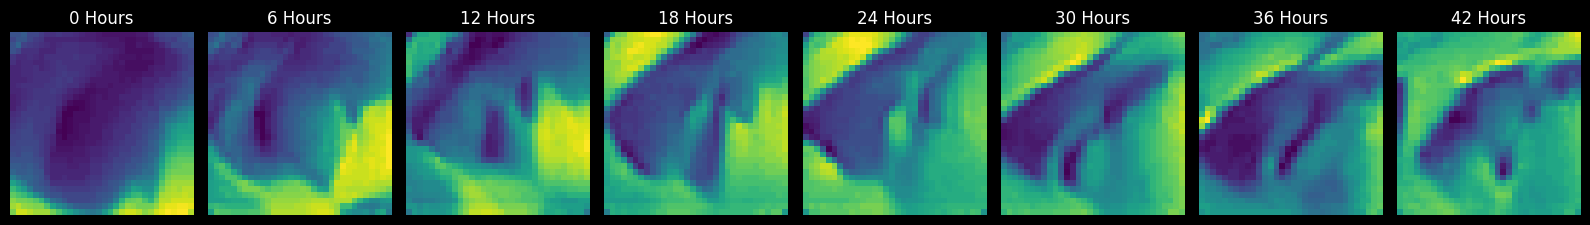

In [68]:
np.asarray(preds[0][0]).max()
import matplotlib.pyplot as plt

# Create a figure with 8 subplots (2 rows, 4 columns)
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(16, 8))
# axes = axes.flatten()  # Flatten to simplify indexing

# Load and plot each .npy file
for i in range(8):
    img = pred[i].mean(axis=-1)
    img = img - img.min() # Load the image data
    img = img*2
    img = img.astype(np.uint8)
    print(img.max(), img.min(), img.shape)
    axes[i].imshow(img, cmap='viridis' if img.ndim == 2 else None)
    axes[i].set_title(f'{i*6} Hours')
    axes[i].axis('off')  # Hide axes for better display

# plt.title('Wind Magnitude Over Time From Storm Detection, 21 January 1988')
# Improve layout and display
plt.tight_layout()
plt.show()


# Eval

In [44]:

import os 
import numpy as np 
realpath = '/home/cyclone/train/windmag_natlantic'

# load all train examples
train=[]
ids = []
for stormdir in sorted(os.listdir(realpath)):
    if not os.path.isdir(os.path.join(realpath, stormdir)) or stormdir=='synth':
        continue
    ids.append(stormdir)
    storm = []
    for i in range(8):
        p = os.path.join(realpath, stormdir, f'{i}.npy')
        img = np.load(p)
        img = np.nan_to_num(img, 0) # replace NAN (missing value) with 0
        storm.append(np.array(img))
    train.append(np.stack(storm))
train = np.stack(train) # concatenate them all together into one matrix
train.shape

(387, 8, 32, 32)

In [45]:
composite=np.mean(train, axis=0) # make a "composite" by averaging over all storms
composite.shape

(8, 32, 32)

In [47]:
composite.mean(), composite.std()

(np.float64(6.233845682705272), np.float64(0.9805870115888183))

In [ ]:
# COMMENTED OUT -- ASSUMES PNG FORMAT BUT NPY FORMAT SYNTHETICS DONT EXIST YET
# load synthetics 
# synth = []
# for stormdir in sorted(os.listdir(synthpath)):
#     if not os.path.isdir(os.path.join(synthpath, stormdir)):
#         continue
#     storm = []
#     for i in range(8):
#         p = os.path.join(synthpath, stormdir, f'{i}.png')
#         img = im.open(p)
#         storm.append(np.array(img))
#     synth.append(np.stack(storm))

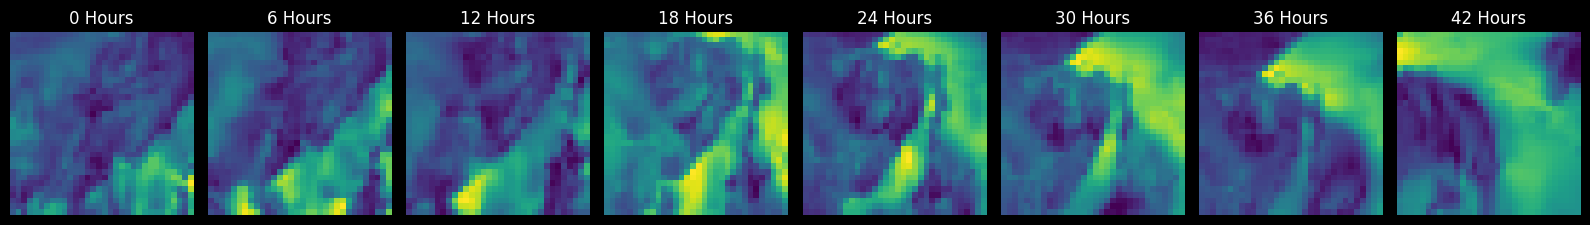

In [16]:
path = '/home/cyclone/train/windmag_atlanticpacific/19880121120440013000'
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with 8 subplots (2 rows, 4 columns)
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(16, 8))
# axes = axes.flatten()  # Flatten to simplify indexing

# Load and plot each .npy file
for i in range(8):
    img = np.load(f'{path}/{i}.npy')  # Load the image data
    axes[i].imshow(img, cmap='viridis' if img.ndim == 2 else None)
    axes[i].set_title(f'{i*6} Hours')
    axes[i].axis('off')  # Hide axes for better display

# plt.title('Wind Magnitude Over Time From Storm Detection, 21 January 1988')
# Improve layout and display
plt.tight_layout()
plt.show()


In [31]:
import numpy as np 
np.asarray(img).min(), np.asarray(img).max()

(np.float32(0.84172505), np.float32(24.489887))